In [1]:
from Grid_to_Graph.GRDECL_Parser import GRDECL_Parser
from Grid_to_Graph.struct_discretizer import StructDiscretizer
import numpy as np
import graph_coarsening.graph_utils as graph_utils
#import graph_coarsening.useful_custom_functions as useful_custom_functions
from graph_coarsening.coarsening_utils import *
from collections import defaultdict
from operator import itemgetter
import pandas as pd
import fileinput
import sys
import os
from pygsp import graphs
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %pylab
plt.rcParams['figure.figsize'] = (11, 9)

In [2]:
def OneDim_to_ThreeDim_Converter(i_max, j_max, k_max, One_Dim):
    # приводим массив к 3D размерности грида.
    Three_Dim = np.reshape(One_Dim, (i_max, j_max, k_max), order='F')

    return Three_Dim


def get_coarsening(Gall, Call, size=5, node_size=20, title=""):
    edges_s = {}

    n_levels = len(Gall) - 1
    for level in range(n_levels):
        G = Gall[level]
        edges = np.array(G.get_edge_list()[0:2])

        Gc = Gall[level + 1]
        edges_c = np.array(Gc.get_edge_list()[0:2])
        C = Call[level]
        C = C.toarray()

        for i in range(Gc.N):
            subgraph = np.arange(G.N)[C[i, :] > 0]
            edges_s[i] = subgraph
            #if np.clip(len(subgraph) - 1, 0, 4) > 0:
            #edges_s[i] = subgraph

    return edges_s


def replaceAll(file, searchExp, replaceExp):    
    for line in fileinput.input(file, inplace=1):
        if searchExp in line:
            line = line.replace(searchExp,replaceExp)
        sys.stdout.write(line)

Считываем данные по гриду

In [3]:
# from grid2graph.data import *
# dataset_list = get_dataset('dataset/', tensor_path='dataset/tensor.pt', i_max=60, j_max=60, z_max=1)
# dataset_list

In [4]:
# poro = []
# perm = []

# for d in tqdm(dataset_list):
#     poro.append(d.x[:, 0].cpu())
#     perm.append(d.x[:, 1].cpu())

# poro = np.concatenate((poro), axis=0)
# permx = np.concatenate((perm), axis=0)

In [5]:
df = pd.read_csv('dataset/EGG.csv')

In [6]:
coords = np.array(OneDim_to_ThreeDim_Converter(60, 60, 1, np.arange(3600) - 1))
coords_new = np.zeros((3600, 3))
for i in range(60):
    for j in range(60):
        for k in range(1):
            if coords[i, j, k] != -1:
                coords_new[int(coords[i, j, k])] = np.array([i, j, k])

In [7]:
dx = 8 
dy = 8
dz = 4

actnum = df['ACTNUM'].to_numpy() #dataset_list[0].label.cpu().numpy()
nx = 60
ny = 60
nz = 1

coord = coords_new

zcorn = 0

permx = df['PERM'].to_numpy() #grid_data.SpatialDatas['PERMX'] * 100
permx[permx<=0] = 0.0002
permy = permx
permz = permy

poro = df['PORO'].to_numpy()  #grid_data.SpatialDatas['PORO']
poro[poro<=0] = 0.0002

volume = np.zeros_like(poro)
volume.fill(dx*dy*dz)

depth = np.zeros_like(poro)
depth.fill(1000)

n = nx * ny * nz

Получаем conection list

In [8]:
discretizer = StructDiscretizer(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, permx=permx, permy=permy,
                                              permz=permz, coord=coord, zcorn=zcorn)

if discretizer.is_cpg:
    cell_m, cell_p, tran, tran_thermal = discretizer.calc_cpg_discr()
else:
    cell_m, cell_p, tran, tran_thermal = discretizer.calc_structured_discr()

Building connection list...


In [9]:
# apply actnum filter if needed - all arrays providing a value for a single grid block should be passed
op_num = 0
arrs = [poro, depth, volume, op_num]

cell_m, cell_p, tran, tran_thermal, arrs_local = discretizer.apply_actnum_filter(actnum, cell_m,
                                                                                 cell_p, tran,
                                                                                 tran_thermal, arrs)
poro, depth, volume, op_num = arrs_local
permx = permx[actnum != 0]


Applying ACTNUM...
Inactive blocks due to ACTNUM:  1109
Inactive connections due to transmissibility:  0
Inactive connections total:  2213
Inactive blocks due to inactive connections:  0


Создаём граф

In [10]:
edges = list(zip(cell_m, cell_p))
#weights = [1/t if t>0 else 1/0.0001 for t in tran]
weights = list(tran)

# Количество вершин в графе
num_vertices = len(set(sum(edges, ())))

# Создание матрицы смежности
adjacency_matrix = np.zeros((num_vertices, num_vertices))
for edge, weight in zip(edges, weights):
    adjacency_matrix[edge[0], edge[1]] = weight
    adjacency_matrix[edge[1], edge[0]] = weight

In [11]:
coords = np.array(OneDim_to_ThreeDim_Converter(nx, ny, nz, np.arange(n) - 1))
coords_new = np.zeros((n, 3))
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            if coords[i, j, k] != -1:
                coords_new[int(coords[i, j, k])] = np.array([i, j, k])

coords_new = coords_new[actnum != 0]

In [12]:
N = coords_new.shape[0]

G = graphs.Graph(adjacency_matrix)

G.set_coordinates(coords_new)


N = G.N
L = G.L.toarray()
S = graph_utils.get_S(G).T

Загрубляем граф

In [16]:
# Parameters
r = 0.15   # the extend of dimensionality reduction (r=0 means no reduction)
k = 10
max_error = None

kmax = int(3 * k)

coarsening_list, err_list = coarsen(G, K=k, r=r, max_error=max_error)

Gall = get_coarsed_graph(G, coarsening_list)


0.0002672237106275606
0.0005543294504924226
0.0006144456135103124
0.0008092604052210706
0.0011063649922977794
0.0012854161005786484
0.0013169452101909895
0.0014280596417400528
0.0016277871961758502
0.0021634201653701578
0.00236760648558344
0.0026179536026270734
0.003055307722244126
0.0032436374528984195
0.0034337270074777117
0.0036262728745582256
0.004268475367072474
0.004819945354525389
0.004996415090298227
0.005575064095504673
0.005631955216158789
0.005905436607639378
0.00599798850190935
0.00628384616078545
0.006539708933854074
0.0067728805447804215
0.006988395651658154
0.007048235894271238
0.00765515279728398
0.00772668166910803
0.008940440174554452
0.009188908838708047
0.00945811839842825
0.009648113235506281
0.009884307195698074
0.010184676537964475
0.010601618497626702
0.010809608763067673
0.011591774485439061
0.012413116561891698
0.01255303422758432
0.012682520638232834
0.013017452051840739
0.013158796920964777
0.014444387748987056
0.014796232951041311
0.014836175660858875
0.015

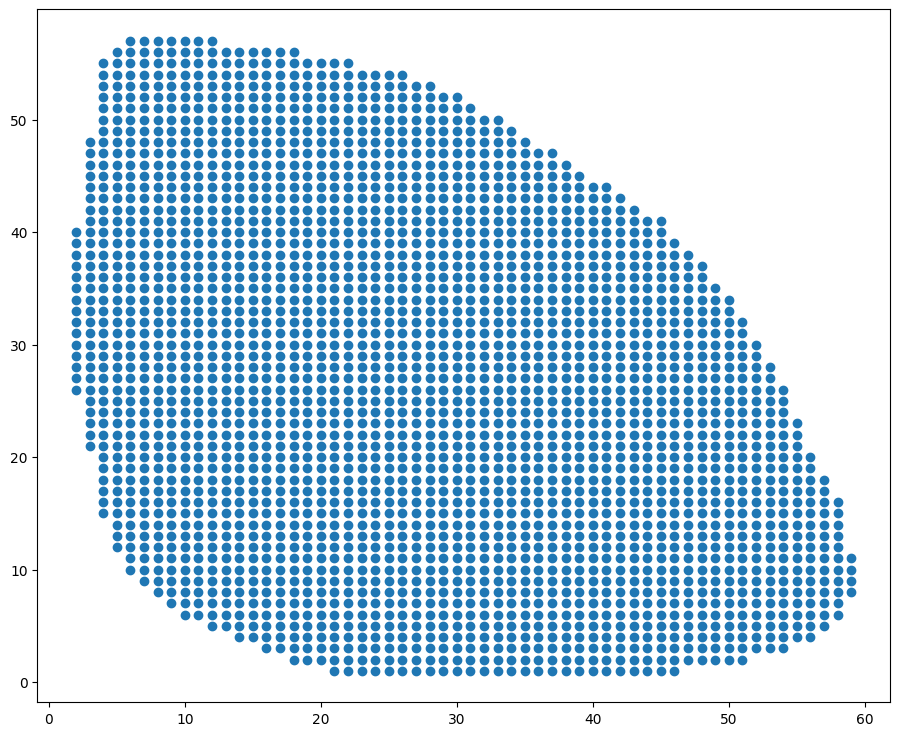

In [17]:
plt.scatter(Gall[0].coords[:,[0]], Gall[0].coords[:,[1]])

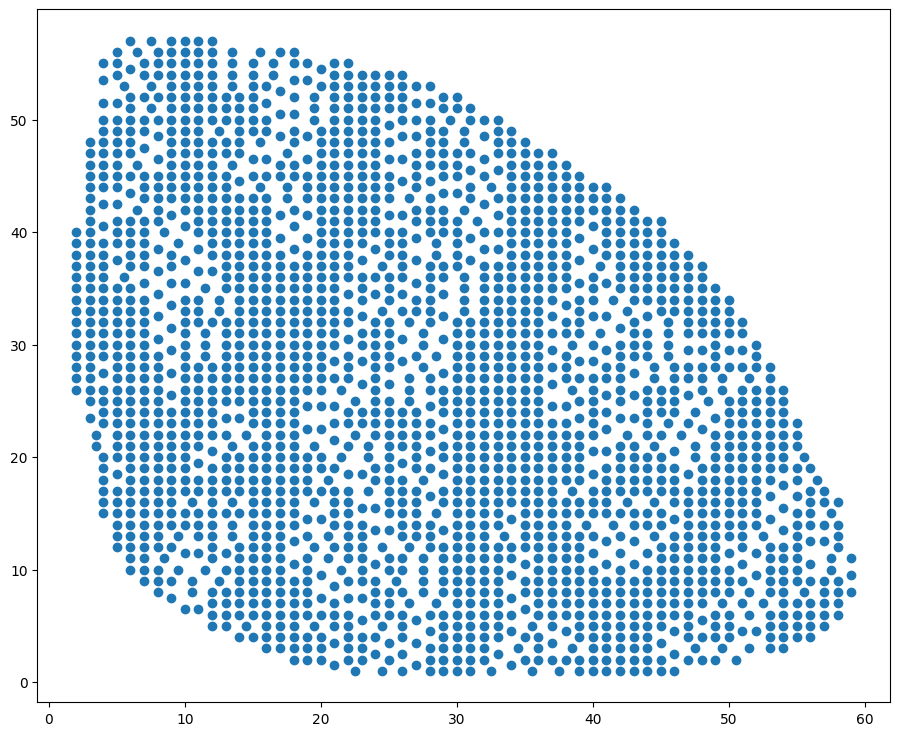

In [18]:
plt.scatter(Gall[1].coords[:,[0]], Gall[1].coords[:,[1]])